In [1]:
import numpy as np
from gym_duckietown.envs import DuckietownEnv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from matplotlib.pyplot import figure
from statistics import mean

In [29]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def is_Yellow(x1,y1,x2,y2,image):
    R1,G1,B1 = image[y1,x1]
    R2,G2,B2 = image[y2,x2]
    
    # Debug colours
#     R = int((int(R1)+int(R2))/2)
#     G = int((int(G1)+int(G2))/2)
#     B = int((int(B1)+int(B2))/2)
#     plt.imshow([[(R,G,B)]])
#     plt.show()
    if mean([B1,B2])*1.7 < mean([R1,G1,R2,G2]):
#         print("Yellow",R,G,B)
        return True
#     print("White",R,G,B)
    return False

def draw_lines(img, lines, image, color=[255, 255, 255], thickness=3):
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8
    )
    img = np.copy(img)
    if lines is None:
        return
    for line in lines:
        for x1, y1, x2, y2 in line:
            if is_Yellow(x1,y1,x2,y2,image):
                cv2.line(line_img, (x1, y1), (x2, y2), [255,255,0], thickness)
            else:
                cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    return img

def pipeline(image):
    """
    An image processing pipeline which will output
    an image with the lane lines annotated.
    """
#     image = np.transpose(image,(1, 2, 0))
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    cannyed_image = cv2.Canny(gray_image, 100, 200)
    print(cannyed_image)
    plt.imshow(cannyed_image)
    plt.show()
    
    height = image.shape[0]
    width = image.shape[1]
    region_of_interest_vertices = [
        (0, 100),
        (0, height),    
        (width, height),
        (width, 100),    
    ]
    cropped_image = region_of_interest(
        cannyed_image,
        np.array(
            [region_of_interest_vertices],
            np.int32
        ),
    )
    
#     # Skip cropping
#     cropped_image = cannyed_image
    
    lines = cv2.HoughLinesP(
        cropped_image,
        rho=1,
        theta=np.pi / 180,
        threshold=30,
        lines=np.array([]),
        minLineLength=100,
        maxLineGap=50
    )
    
    good_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
#             slope = (y2 - y1) / (x2 - x1) # <-- Calculating the slope.
#             if math.fabs(slope) > 0.2: # <-- Only consider extreme slope
            good_lines.append(line)

    line_image = draw_lines(np.zeros_like(image),good_lines,image)
    return np.transpose(line_image,(2,0,1))

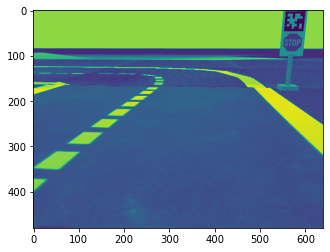

(3, 480, 640)

In [21]:
obs2 = np.transpose(obs,(2, 0, 1))
pipeline(obs2).shape

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


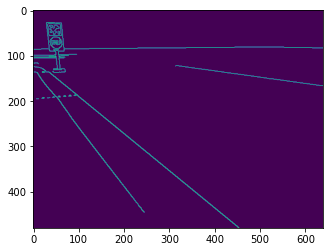

TypeError: Invalid shape (3, 480, 640) for image data

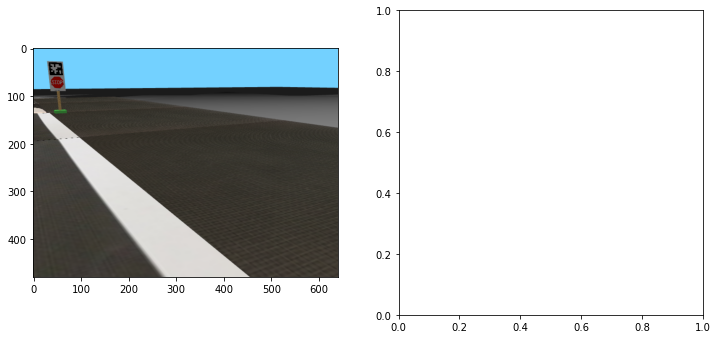

In [30]:
SEED = 11
MAP = 'map5'
env = DuckietownEnv(
    map_name = MAP, domain_rand = False, draw_bbox = False,
    max_steps = 1500,
    seed = SEED)

obs = env.reset()
total_reward = 0
# actions = np.loadtxt('./map5_seed11.txt', delimiter=',')
L = [0.15,1]
R = [0.15,-1]
F = [1,0]
S = [0.15,0]
actions = np.array([L,L,L,L,L,L,L,L,L,L,L,L,L,L,F,F,F,F,F,F,F,F,F,F])
time = len(actions)

i= 0

for (speed, steering) in actions:

    obs, reward, done, info = env.step([speed, steering])
    total_reward += reward
    
    line_image = pipeline(obs)
    figure(figsize=(12, 9))
    plt.subplot(1, 2, 1)
    plt.imshow(obs)
    plt.subplot(1, 2, 2)
    plt.imshow(line_image) 
    plt.show()
    
    print('Steps = %s, Timestep Reward=%.3f, Total Reward=%.3f' % (env.step_count, reward, total_reward))
    i+=1
    if i > time:
        break

print("Total Reward", total_reward)

In [26]:
def process_classes(img_orig: np.ndarray, img_ant: np.ndarray):
    img_orig = img_orig.astype(np.int16)
    img_ant = img_ant.astype(np.int16)
    img_diff = img_ant - img_orig

    b, g, r = cv2.split(img_diff)
    leftLane = b > 0
    rightLane = g > 0
    obstacles = (r > 0) | ((r >= 0) & ((b < 0) | (g < 0)))
    categories = [leftLane, rightLane, obstacles]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    categories = [x.astype(np.uint8) for x in categories]
    categories = [cv2.morphologyEx(x, cv2.MORPH_OPEN, kernel) for x in categories]
    categories = [cv2.morphologyEx(x, cv2.MORPH_CLOSE, kernel) for x in categories]
    categories = tuple((x.astype(np.bool8) for x in categories))

    leftLane, rightLane, obstacles = categories

    res_gray = np.zeros(img_orig.shape[:-1], np.uint8)
    res_gray[rightLane] = 1  # Right lane
    res_gray[leftLane] = 2  # Left lane
    res_gray[obstacles] = 3  # Obstacles

    return res_gray

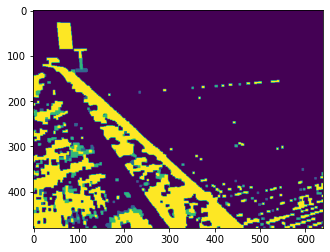

In [32]:
output = process_classes(collect[0],collect[1])
plt.imshow(output)